In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The relevant data set is collected in the subfolder "data". Note, that the data itself is not part of the repository and should be downloaded from  https://survey.stackoverflow.co/

In [29]:
df = pd.read_csv('./data/stack-overflow-developer-survey-2024/survey_results_public.csv')
print('total number of participants:', len(df))

# focus on professional developer, who provided information on their working tools
# df['TBranch'].value_counts(dropna=False)
prof_developers = df.loc[df['TBranch'] == 'Yes']
prof_developers = prof_developers.dropna(subset=['ProfessionalQuestion','ProfessionalTech'])
print('number of prof_developer:', len(prof_developers))



total number of participants: 65437
number of prof_developer: 27643


Question 1: Why is the percentage of professional developers who have access to AI-tools in the company so low?

Consider the variable 'AIChallenge', which refers to the question: "What are the challenges to your company/whole team using AI code assistants or GenAI tools? Select all that apply."

In [139]:
def check_for_AITool(df):
    assert 'ProfessionalTech' in df.columns, "Error: 'ProfessionalTech' column not found"
    df['AIToolsAvailable'] = df['ProfessionalTech'].apply(lambda x: 'AI-assisted technology tool' in x)
    

In [140]:
check_for_AITool(prof_developers)
prof_developers['AIToolsAvailable'].value_counts()

AIToolsAvailable
False    18684
True      8959
Name: count, dtype: int64

In [145]:
#prof_developers['AIChallenges'].value_counts(dropna=False)
import pandas as pd
import pandas as pd
import pandas as pd
test = prof_developers.dropna(subset=['AIChallenges']).copy()
#len(test)
test['AIChallenges'] = test['AIChallenges'].apply(lambda x: x.split(';'))
#test['AIChallenges'].head(10)

# one-hot encoding
unique_values = set(sentence for sublist in test['AIChallenges'] for sentence in sublist)
print(unique_values)

for sentence in unique_values:
    test[sentence] = test['AIChallenges'].apply(lambda x: 1 if sentence in x else 0)

#test['Lack of executive buy-in'].value_counts()
liste_dfs = []
for i in unique_values:
    tmp = test[['ResponseId',i,'AIToolsAvailable']].groupby([i,'AIToolsAvailable']).count().reset_index()
    liste_dfs.append(pd.pivot_table(tmp, values='ResponseId', index=[i], columns=['AIToolsAvailable']))
print(liste_dfs[6])

{'Lack of executive buy-in', 'Lack of proper training and education on new tools', 'Not everyone uses them', 'We don’t have the right policies in place to reduce security risks', 'Other (please specify):', 'They create more work (more code/PRs to review, etc.)', 'Don’t trust the output or answers', 'AI tools lack context of codebase,  internal architecture, and/or company knowledge'}
AIToolsAvailable                    False   True 
Don’t trust the output or answers                
0                                  4383.0  2408.0
1                                  7628.0  4895.0


Question 2: Why is the percentage of professional developer who first try to solve a problem with AI search tools so low? Is there a bias, i.e. no AI search tools available at workplace?

Consider the variable 'PrefessionalQuestion', which refers to the question: "When you have a technical question at work, where do you first go to get an answer?"

In [102]:
# shorter descriptions for plotting
dic_rename_PQ = {
    'Do search of internal share drives/storage locations for documentation (i.e., not a structured knowledge base)' : 'internal unstructured knowledge base'
}
df['ProfessionalQuestion'] = df['ProfessionalQuestion'].replace(dic_rename_PQ)

prof_developers['ProfessionalQuestion'].value_counts()

ProfessionalQuestion
Traditional public search engine        15166
A coworker                               5100
AI-powered search (free)                 2120
AI-powered search (paid)                 1889
Slack search                             1024
internal unstructured knowledge base      900
Internal Developer portal                 759
Other:                                    544
Microsoft Teams search                    141
Name: count, dtype: int64

Text(0, 0.5, '')

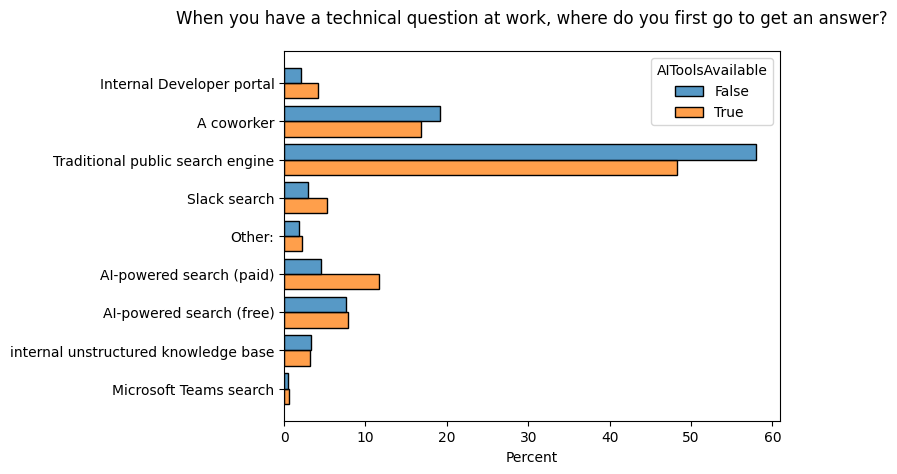

In [112]:
# create visualization
# note, the plot shows the percentages with respect to the subgroups AIToolsAvailable
# AIToolsAvailable=True accounts only for approximately 1/3 of professional developers
sns.histplot(data=prof_developers, y='ProfessionalQuestion', stat="percent", hue='AIToolsAvailable', multiple='dodge',common_norm=False, shrink=0.8)
plt.title('When you have a technical question at work, where do you first go to get an answer?',pad=20)
plt.ylabel('')

Question 3:  How does the distribution of "ProfessionalQuestion" look like for different age groups?

Text(0, 0.5, '')

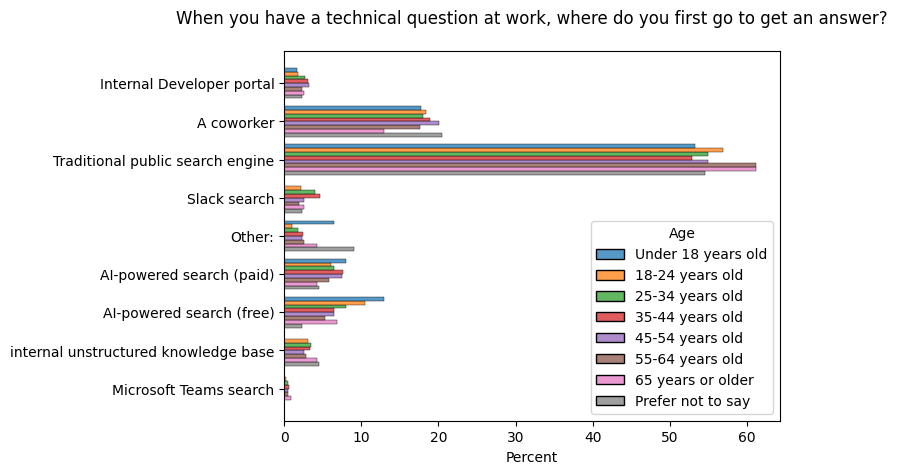

In [111]:

sns.histplot(data=prof_developers, y='ProfessionalQuestion', stat="percent", 
             hue='Age', multiple='dodge',common_norm=False, shrink=0.8,
             hue_order=['Under 18 years old', '18-24 years old', '25-34 years old',
            '35-44 years old', '45-54 years old', '55-64 years old', '65 years or older', 'Prefer not to say'])
plt.title('When you have a technical question at work, where do you first go to get an answer?',pad=20)
# plt.tight_layout()
plt.ylabel('')

In [106]:
prof_developers['Age'].value_counts()

Age
25-34 years old       12038
35-44 years old        7717
18-24 years old        3834
45-54 years old        2881
55-64 years old         951
65 years or older       116
Under 18 years old       62
Prefer not to say        44
Name: count, dtype: int64

Summarize the values with respect to AI context

In [ ]:
# def determine_first_advisor(df):
    
#     assert 'ProfessionalQuestion' in df.columns, "Error: 'ProfessionalQuestion' column not found"
#     df['FirstAdvisor'] = df['ProfessionalQuestion'].apply(lambda x: ('AI-powered search (paid)' in x or 'AI-powered search (free)' in x))
#     df['FirstAdvisor'] = df['FirstAdvisor'].replace({1: 'AI', 0: 'NonAI'})

# determine_first_advisor(prof_developers)
# prof_developers['FirstAdvisor'].value_counts()

In [119]:
df = pd.DataFrame({
    'Features': [['Hallo', 'abc'], ['Ciao', 'servus', 'abc'], ['abc'], ['servus'], ['Hallo', 'servus']]
})

# 1. Eindeutige Wörter aus den Listen ermitteln
unique_values = set(word for sublist in df['Features'] for word in sublist)

# 2. Erstellen von "one-hot" kodierten Spalten für jedes eindeutige Wort
for word in unique_values:
    df[word] = df['Features'].apply(lambda x: 1 if word in x else 0)

print(df)

              Features  Ciao  abc  Hallo  servus
0         [Hallo, abc]     0    1      1       0
1  [Ciao, servus, abc]     1    1      0       1
2                [abc]     0    1      0       0
3             [servus]     0    0      0       1
4      [Hallo, servus]     0    0      1       1
